# Reddit Churn Analysis
* Instructor: `Shahbaz Chaudhary`
* Team: MSCA Data Scientists 
  * `Zoila Joyo Calderon`
  * `Lauren Sample`
  * `Ruobing Xue`
  * `Elly Yang`

## Load Data

In [1]:
import numpy as np
import pandas as pd
DF = pd.read_feather('RC_2012_year_cohort.feather')
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234225454 entries, 0 to 234225453
Data columns (total 3 columns):
 #   Column       Dtype   
---  ------       -----   
 0   created_utc  int64   
 1   author       category
 2   subreddit    category
dtypes: category(2), int64(1)
memory usage: 3.6 GB


In [2]:
DF.head()

,created_utc,author,subreddit
0,1325376000,irwinator,AskReddit
1,1325376000,reed311,politics
2,1325376000,sagapo3851,gaming
3,1325376000,filthgrinder,politics
4,1325376001,BitterDivorcedDad,WTF


## Find the top 30 subreddits

In [3]:
top30 = DF.groupby('subreddit').size().sort_values(ascending=False)[:30].index.tolist()
top30

['AskReddit',
 'funny',
 'pics',
 'gaming',
 'WTF',
 'politics',
 'atheism',
 'leagueoflegends',
 'IAmA',
 'trees',
 'videos',
 'AdviceAnimals',
 'todayilearned',
 'fffffffuuuuuuuuuuuu',
 'worldnews',
 'gonewild',
 'nfl',
 'movies',
 'starcraft',
 'aww',
 'technology',
 'Minecraft',
 'soccer',
 'Music',
 'nba',
 'Diablo',
 'mylittlepony',
 'Guildwars2',
 'Games',
 'guns']

## Zoom in on one subreddit

In [4]:
# using subreddit 'guns' as an example
df = DF.loc[DF['subreddit']=='guns', ['created_utc', 'author']]
df.head()

,created_utc,author
60,1325376008,Pomberella2
62,1325376009,CountNefarious
132,1325376024,mt3chn1k
237,1325376042,[deleted]
300,1325376052,lokiusmc


## Find the date of first interaction for that subreddit

In [5]:
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s').dt.date
day0 = df.groupby('author').agg({'created_utc': np.min}).sort_values(by='created_utc')
day0.rename(columns={'created_utc': 'day0'}, inplace=True)
day0.head()

,day0
author,
n4ggs,2012-01-01
ThebestLlama,2012-01-01
Dubbys,2012-01-01
veriix,2012-01-01
versalius,2012-01-01


## Combine the initial dataframe with comment timestamps

In [6]:
df_merged = pd.merge(df, day0, left_on='author', right_index=True)
df_merged['nDays'] = (df_merged['created_utc'] - df_merged['day0']).dt.days
df_merged.drop(['created_utc', 'day0'], axis=1, inplace=True)
df_merged.drop_duplicates(inplace=True)
df_merged.head()

,author,nDays
60,Pomberella2,0
62,CountNefarious,0
59941791,CountNefarious,106
60911409,CountNefarious,107
72253992,CountNefarious,125


## Pivot the dataframe with authors on one axis and days they commented on another

In [7]:
df_merged['commented'] = 1
df_pivot = df_merged.pivot(index='nDays', columns='author', values='commented')
df_pivot.head()

author,Pomberella2,CountNefarious,mt3chn1k,[deleted],lokiusmc,i2ndshenanigans,EvilJew,drewmsmith,alsimone,FirearmConcierge,...,_Old_Man_Jenkins_,another_new_username,chsp73,Anthmt,judenPWNS,phulton,mcaok,TheDuckontheJuneBug,datkidbrad,Averyce
nDays,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Sum the number of commenters for each day

In [8]:
daySum = df_pivot.sum(axis=1)
daySum.head()

nDays
0    34145.0
1     5078.0
2     2796.0
3     2293.0
4     2082.0
dtype: float64

## Calculate the % of authors who returned after their first comment

In [9]:
dayPer = daySum/daySum[0]
dayPer.head()

nDays
0    1.000000
1    0.148719
2    0.081886
3    0.067155
4    0.060975
dtype: float64

## Plot retention rate

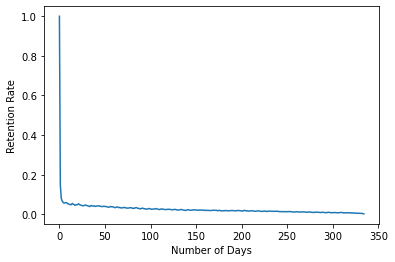

In [10]:
import matplotlib.pyplot as plt
dayPer.plot()
plt.xlabel('Number of Days')
plt.ylabel('Retention Rate');

## Put everything together

In [11]:
def getSub(nameSub):
    df = DF.loc[DF['subreddit'] == nameSub, ['created_utc', 'author']]
    
    df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s').dt.date
    day0 = df.groupby('author').agg({'created_utc': np.min}).sort_values(by='created_utc')
    day0.rename(columns={'created_utc': 'day0'}, inplace=True)
    
    df_merged = pd.merge(df, day0, left_on='author', right_index=True)
    df_merged['nDays'] = (df_merged['created_utc'] - df_merged['day0']).dt.days
    df_merged.drop(['created_utc', 'day0'], axis=1, inplace =True)
    df_merged.drop_duplicates(inplace=True)

    df_merged['commented'] = 1
    df_pivot = df_merged.pivot(index='nDays', columns='author', values='commented')
    
    daySum = df_pivot.sum(axis=1)

    dayPer = daySum/daySum[0]
    return dayPer.to_frame(nameSub)

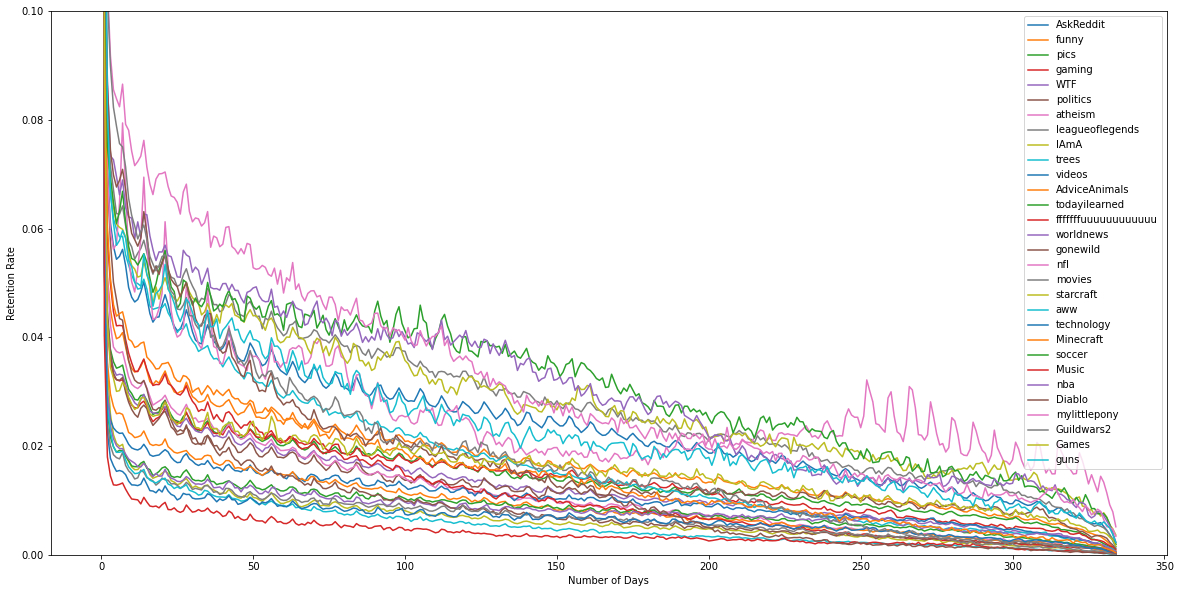

In [12]:
plt.figure(figsize=(20, 10))
ax = plt.gca()
for i in top30: getSub(i).plot(ax=ax)
plt.xlabel('Number of Days')
plt.ylabel('Retention Rate')
plt.ylim(0, 0.1);